In [2]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")

import torch
from torch.utils.data import DataLoader, Dataset

def read_input():
    nc_name = 'Inputs_vertical_levels.nc'
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/CNN_DATA/{0}'.format(nc_name),'r')
    inputs_test = np.asfortranarray(nc.variables['inputs_test'])
    inputs_train = np.asfortranarray(nc.variables['inputs_train'])
    nc.close()
    return(inputs_test,inputs_train)

def read_output():
    nc_name = 'pdf_vertical_levels.nc'
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/OUTPUTS/PDF/{0}'.format(nc_name),'r')
    pdf_test = np.asfortranarray(nc.variables['pdf_test'])*((80/5)**2)
    pdf_train = np.asfortranarray(nc.variables['pdf_train'])*((80/5)**2)
    nc.close()
    return(pdf_test,pdf_train)

class Pdf_Image_DataSet(Dataset):
    def __init__(self,images, pdf,transform=None):
        
        self.pdf = pdf
        self.images = images
        self.transform = transform

    def __len__(self):
        return self.pdf.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        pdf_sample = self.pdf[idx,:,:,:,:]
        image_sample = self.images[idx,:,:,:]
        
        if self.transform:
            pdf_sample = self.transform(pdf_sample)
            image_sample = self.transform(image_sample)
            
        return image_sample, pdf_sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

from torch import nn
from torch import optim
import progressbar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# hyperparameters
batch_size = 30


(pdf_test,pdf_train) = read_output()
(inputs_test,inputs_train) = read_input()

## reduce size dataset
train_set = Pdf_Image_DataSet(inputs_train,pdf_train,transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

test_set = Pdf_Image_DataSet(inputs_test,pdf_test,transform= ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [4]:
# Check the shape of inputs and outputs

for X, y  in test_loader:
    X, y  = X.to(device), y.to(device)
    print("Shape of X [N, C, H, W]: ", X.shape,X.device)
    print("Shape of y: ", y.shape, y.device)
    break

Shape of X [N, C, H, W]:  torch.Size([30, 52, 100, 100]) cuda:0
Shape of y:  torch.Size([30, 9, 1, 50, 50]) cuda:0


In [5]:
from torch import nn
from torch import optim
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

def bhatta_loss(output,target):
    epsilone = 1e-30
    out = torch.sum(1 - torch.sum(torch.sqrt(torch.abs((torch.mul(output, target)+epsilone))),axis=(2,3)))
    return out

In [59]:
# Achitecture of the model 

class cnn_parallele(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(    
            
            nn.Conv2d(53, 26, kernel_size = 5, padding = 2),
            nn.ReLU(True),
            #nn.AvgPool2d(2),
            nn.Conv2d(26, 1, kernel_size = 5, padding = 2),
            nn.Flatten(start_dim=1, end_dim=- 1),
            #nn.Softmax(dim=1)
    )

        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten(start_dim=1, end_dim=- 1)
        self.avgpool2d = nn.AvgPool2d(2)
        
    def forward(self, z, y):
        
        y_hat = torch.clone(y)
        z = self.avgpool2d(z)
        
        for i in range(1,9,1):
            
            z_i = torch.cat((z,y_hat[:,i-1,:,:,:]),dim =1)
            out = self.cnn(z_i)
            y_before = self.flatten(y_hat[:,i-1,:,:,:])
            out =  y_before + out
            out = self.softmax(out)
            y_hat[:,i,:,:,:] = out.view(out.shape[0],1,50,50)
        
        return y_hat
    
    def configure_optimizers(self):
        lr = 0.001
        optimizer = optim.Adam(self.parameters(),lr= lr, betas=(0.5, 0.999),weight_decay=0)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x,y)
        #loss = bhatta_loss(y_hat, y)
        loss = 10e6*F.mse_loss(y_hat, y)
        #self.log("my_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x,y)
        val_loss = bhatta_loss(y_hat, y)
        #val_loss = nn.MSELoss(y_hat, y)
        self.log('valid_loss', val_loss, on_step=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x,y)
        #loss = bhatta_loss(y_hat, y)
        loss = 10e6*F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss
    
    '''
    def validation_epoch_end(self,outputs):
        
        val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        x_hat = outputs[-1]['x_hat']

        grid = torchvision.utils.make_grid(x_hat)
        self.logger.experiment.add_image('images', grid, 0)

        log = {'avg_val_loss': val_loss}
        return {'log': log, 'val_loss': val_loss}
    '''

In [60]:
weights_init(autoencoder)

In [61]:
# init model
autoencoder = cnn_parallele()
trainer = pl.Trainer(max_epochs=10,gpus=1) #(if you have GPUs)
#trainer = pl.Trainer()
trainer.fit(model=autoencoder, train_dataloaders=train_loader,val_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-dcb0ca9d-55d4-28a2-1aa7-2638e1a18e28]

  | Name      | Type       | Params
-----------------------------------------
0 | cnn       | Sequential | 35.1 K
1 | softmax   | Softmax    | 0     
2 | flatten   | Flatten    | 0     
3 | avgpool2d | AvgPool2d  | 0     
-----------------------------------------
35.1 K    Trainable params
0         Non-trainable params
35.1 K    Total params
0.141     Total estimated model params size (MB)


Epoch 0:  91%|█████████ | 164/181 [00:12<00:01, 12.65it/s, loss=592, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 164/181 [00:12<00:01, 12.79it/s, loss=542, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 164/181 [00:12<00:01, 12.64it/s, loss=561, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 3:  91%|█████████ | 164/181 [00:12<00:01, 12.81it/s, loss=626, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|█████████ | 164/181 [00:12<00:01, 12.93it/s, loss=534, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 5:  91%|█████████ | 164/181 [00:12<00:01, 12.89it/s, loss=542, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 6:  91%|█████████ | 164/181 [00:12<00:01, 12.82it/s, loss=548, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 7:  91%|█████████ | 164/181 [00:12<00:01, 12.89it/s, loss=544, v_num=61]
Validating: 0it [00:00, ?it/s]
Epoch 8:  33%|███▎      | 59/181 [00:04<00:09, 12.84it/s, loss=528, v_num=61] 

In [1]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/version_15'

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [45]:
autoencoder.device

device(type='cpu')

# Visual test on the last prediction

Epoch 7:  98%|█████████▊| 178/181 [02:14<00:02,  1.32it/s, loss=629, v_num=60]

                                                           

<ipython-input-62-203c0cc2df49>:49: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(lon, lat, y[n_sample,8,0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)


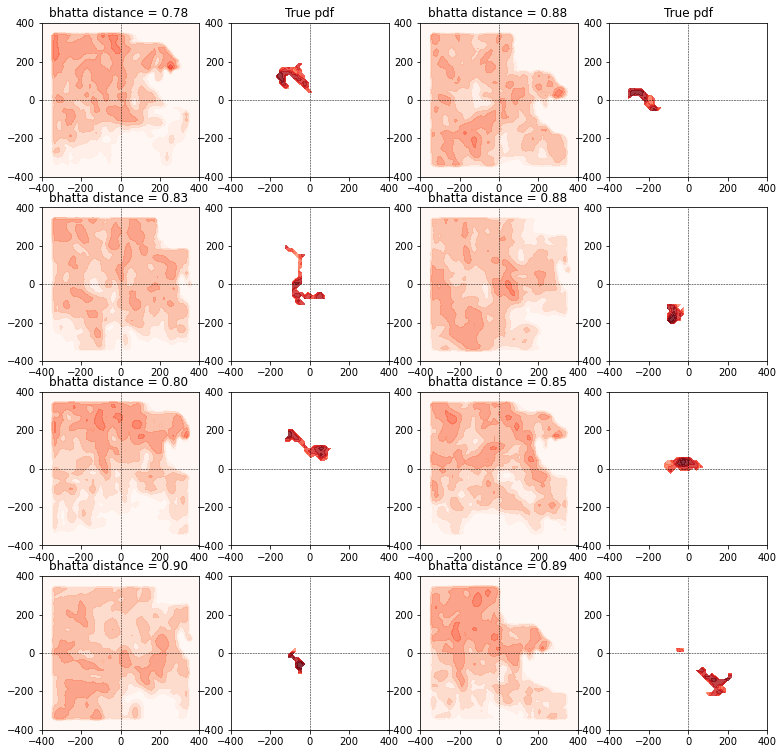

Epoch 8:  33%|███▎      | 59/181 [00:14<00:29,  4.09it/s, loss=528, v_num=61]

In [62]:
with torch.no_grad():
    for batch, (X, y ) in enumerate(test_loader):
        X, y  = X.to(device), y.to(device)
        autoencoder = autoencoder.to(device)
        pred = autoencoder(X,y)[:,8,:,:,:]

        
xband, yband = np.linspace(-400,400,51), np.linspace(-400,400,51)

fig = plt.figure(figsize=(13,13))

#n_sample = 3
i = 0
levels=np.logspace(-4, -1, 10)
cmap = 'Spectral_r' 
cmap = 'Reds'
cmap_blue = 'Blues' 
norm= colors.LogNorm(vmin=1e-4, vmax=1e-1)
lon = np.linspace(-400,400,50)
lat = np.linspace(-400,400,50)

for n_sample in range(0,8,1):
    
    ax = fig.add_subplot(4,4,i*2+1)
    
    #cb.ax.tick_params(labelsize='large')
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, pred[n_sample,0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
    loss_prediction = 1 - torch.sum(torch.sqrt(torch.abs((torch.mul(pred[n_sample,0,:,:], y[n_sample,8,0,:,:])))))
    loss_prediction = np.round(loss_prediction.cpu().detach().numpy(),3)
    '''
    plt.pcolormesh(lon,lat,pred[n_sample,0,:,:].cpu().detach().numpy(),cmap = plt.cm.Reds,alpha = 1)
    #plt.pcolormesh(lon,lat,y[n_sample,0,:,:].cpu().detach().numpy(),cmap = plt.cm.Blues,alpha = 0.5)
    '''
    #if i == 3 : plt.xlabel('km', fontsize=12)
    #plt.ylabel('km', fontsize=12)
    plt.title('bhatta distance = {:.2f} '.format(loss_prediction))
    #cb = plt.colorbar()
    #cb.set_ticks([1e-3, 1e-2])
    
    ax = fig.add_subplot(4,4,i*2+2)
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, y[n_sample,8,0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
    '''
    plt.pcolormesh(lon,lat,y[n_sample,0,:,:].cpu().detach().numpy(),cmap = plt.cm.Reds)
    '''
    #if i == 3 : plt.xlabel('km', fontsize=12)
    #plt.ylabel('km', fontsize=12)
    if i ==0 : plt.title('True pdf')
    if i ==1 : plt.title('True pdf')
    #cb = plt.colorbar()
    #cb.set_ticks([1e-3, 1e-2])
    
    i = i+1
#plt.savefig('test_prediction_mse_dropout.png')

torch.Size([20, 1, 50, 50])

torch.Size([500, 1])


<ipython-input-22-797efcf772e3>:74: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(lon, lat, y_min[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
<ipython-input-22-797efcf772e3>:94: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(lon, lat, y_max[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)


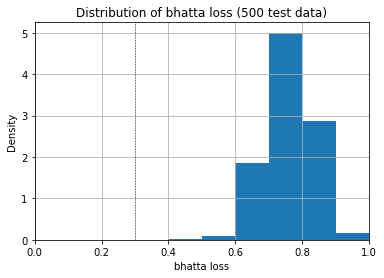

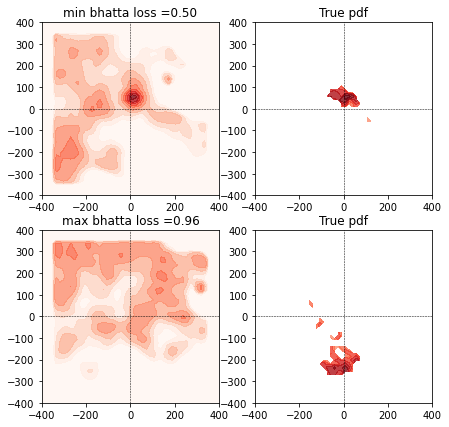

In [23]:
loss_distribution(test_loader,autoencoder.to(device))

In [63]:
def loss_distribution(test_loader,model):

    max_bhatta = 0
    min_bhatta = 1
    
    i =0
    with torch.no_grad():
        for batch, (X, y) in enumerate(test_loader):

            # TRAIN MODEL
            X, y = X.to(device), y.to(device)
            prediction_test = model(X,y)[:,8,:,:,:]
            loss_prediction_test = 1 - torch.sum(torch.sqrt(torch.abs((torch.mul(prediction_test, y[:,8,:,:,:])))),axis=(2,3))
            if i ==0:
                bhatta_list = loss_prediction_test
                i=i+1
            else :
                bhatta_list = torch.cat((bhatta_list,loss_prediction_test),0)
            
            if torch.max(loss_prediction_test) > max_bhatta : 
                max_bhatta = torch.max(loss_prediction_test)
                index = torch.argmax(loss_prediction_test )
                prediction_max = prediction_test[index,:,:,:]
                y_max = y[index,8,:,:,:]

            if torch.min(loss_prediction_test) < min_bhatta : 
                min_bhatta = torch.min(loss_prediction_test)
                index = torch.argmin(loss_prediction_test )
                prediction_min = prediction_test[index,:,:,:]
                y_min = y[index,8,:,:,:]

    min_bhatta = np.round(min_bhatta.cpu().detach().numpy(),3)
    max_bhatta = np.round(max_bhatta.cpu().detach().numpy(),3)
    
    bin = np.linspace(0,1,11)
    plt.hist(bhatta_list.cpu().detach().numpy(), bins=bin, density=True)
    plt.title('Distribution of bhatta loss (500 test data)')
    plt.xlabel('bhatta loss')
    plt.ylabel('Density')
    plt.grid()
    plt.axvline(x=0.3,color='black',linestyle='--',linewidth=0.5)
    plt.xlim(0,1)
    
    xband, yband = np.linspace(-400,400,51), np.linspace(-400,400,51)
    #bhatta_list = np.array(bhatta_list)
    print(bhatta_list.shape)
    fig = plt.figure(figsize=(7,7))

    #n_sample = 3
    i = 0
    levels=np.logspace(-4, -1, 10)
    cmap = 'Spectral_r' 
    cmap = 'Reds'  
    norm= colors.LogNorm(vmin=1e-4, vmax=1e-1)
    lon = np.linspace(-400,400,50)
    lat = np.linspace(-400,400,50)

    ax = fig.add_subplot(2,2,1)
    plt.title('min bhatta loss ={:.2f}'.format(min_bhatta))
    #cb.ax.tick_params(labelsize='large')
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, prediction_min[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

    ax = fig.add_subplot(2,2,2)
    plt.title('True pdf')
    #cb.ax.tick_params(labelsize='large')
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, y_min[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

    ax = fig.add_subplot(2,2,3)
    plt.title('max bhatta loss ={:.2f}'.format(max_bhatta))
    #cb.ax.tick_params(labelsize='large')
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, prediction_max[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

    ax = fig.add_subplot(2,2,4)
    plt.title('True pdf')
    #cb.ax.tick_params(labelsize='large')
    ax.set_xlim([-400,400])
    ax.set_ylim([-400,400])

    plt.contourf(lon, lat, y_max[0,:,:].cpu().detach().numpy(),  levels, norm=norm, cmap=cmap, extend='both',alpha = 0.8)
    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
    
    return

In [91]:
np.sum(pred[n_sample,0,:,:].cpu().detach().numpy())

1.0

<ipython-input-64-04bc2b4bf27d>:21: UserWarning: Log scale: values of z <= 0 have been masked
  ctf = ax.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), jpdf,  levels, norm=norm, cmap=cmap, extend='both')


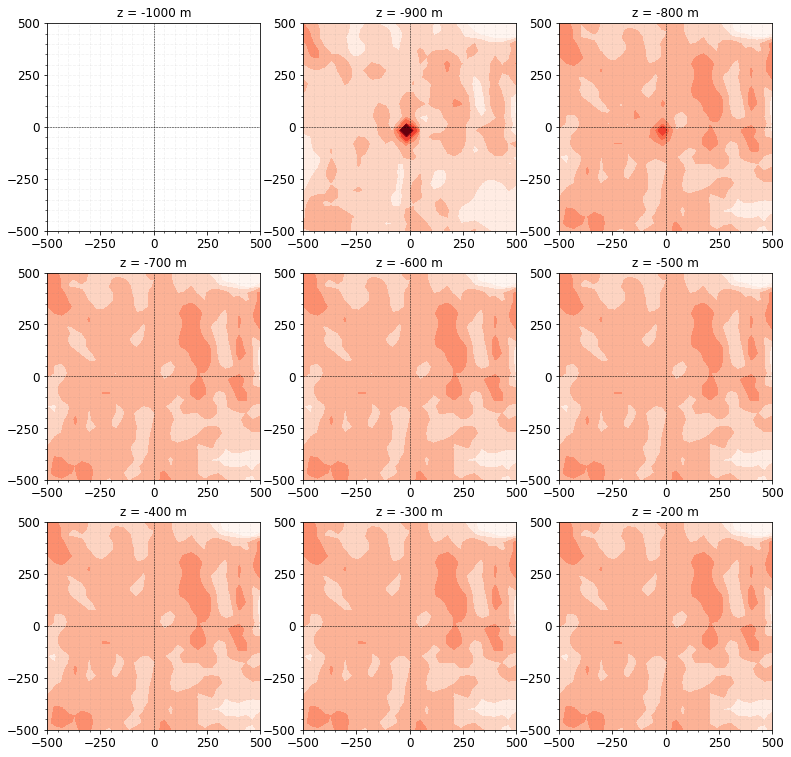

In [64]:
%matplotlib inline
with torch.no_grad():
    for batch, (X, y) in enumerate(test_loader):

        # TRAIN MODEL
        X, y = X.to(device), y.to(device)
        prediction_test = autoencoder(X,y)
        
list_level = [1000,900,800,700,600,500,400,300,200]
fig = plt.figure(figsize=(13,13))

for n in range(9):

    ax = fig.add_subplot(3,3,n+1)
    cmap = 'Spectral_r'
    cmap = 'Reds'
    xband, yband = np.linspace(-800,800,51), np.linspace(-800,800,51)
    jpdf = prediction_test[0,n,0,:,:].cpu().detach().numpy()
    levels=np.logspace(-4, -1, 10)
    norm= colors.LogNorm(vmin=1e-4, vmax=1e-1)
    ctf = ax.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), jpdf,  levels, norm=norm, cmap=cmap, extend='both')
    #cb = fig.colorbar(ctf, ax=ax)
    #cb.set_ticks([1e-5, 1e-4])
    #cb.set_label('[km' + r'$^{-2}$' + ']', fontsize=16, rotation=270)
    ax.set_xlim([-500,500])
    ax.set_ylim([-500,500])

    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
    plt.xticks([-500,-250,0,250,500])
    plt.yticks([-500,-250,0,250,500])
    #plt.text(600,600,'[km' + r'$^{-2}$' + ']', fontsize=16)
    #plt.xlabel('[km]', fontsize=20)
    #plt.ylabel('[km]', fontsize=20)
    #plt.text(-650,600,'[km]', fontsize=20)
    #plt.text(600,-600,'[km]', fontsize=20)
    #plt.text(-600, 650, '(' + label[i] + ')', fontsize=20)
    plt.tick_params(labelsize=12)
    plt.grid(b=True, which='major', color='gray', linestyle='--',alpha=0.1)
    plt.grid(b=True, which='minor', color='gray', linestyle='--',alpha=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    plt.title('z = {0} m'.format(-list_level[n]), fontsize=12)

<ipython-input-65-73565fe02c3f>:21: UserWarning: Log scale: values of z <= 0 have been masked
  ctf = ax.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), jpdf,  levels, norm=norm, cmap=cmap, extend='both')


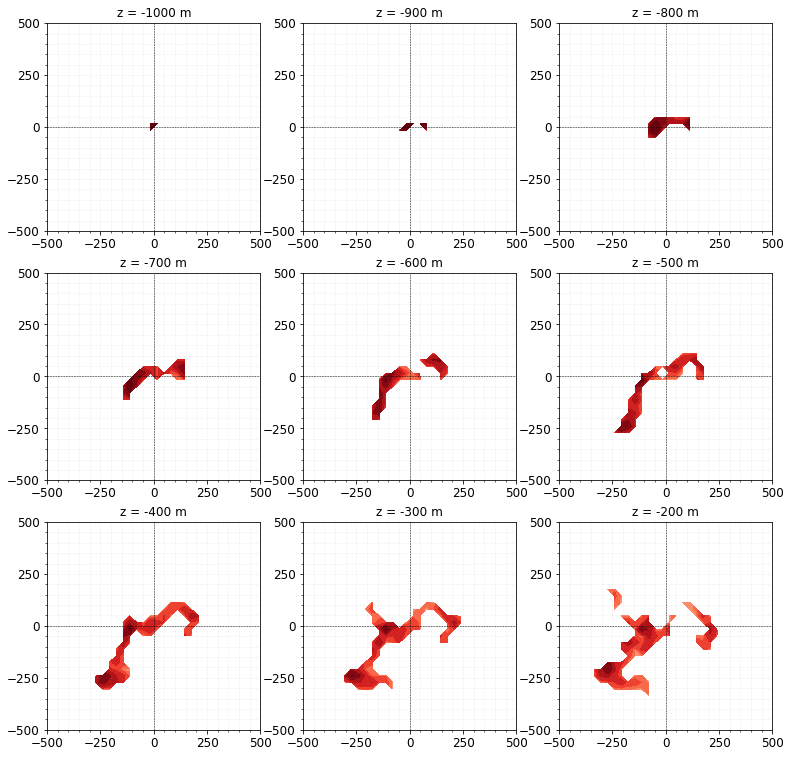

In [65]:
%matplotlib inline
with torch.no_grad():
    for batch, (X, y) in enumerate(test_loader):

        # TRAIN MODEL
        X, y = X.to(device), y.to(device)
        prediction_test = y
        
list_level = [1000,900,800,700,600,500,400,300,200]
fig = plt.figure(figsize=(13,13))

for n in range(9):

    ax = fig.add_subplot(3,3,n+1)
    cmap = 'Spectral_r'
    cmap = 'Reds'
    xband, yband = np.linspace(-800,800,51), np.linspace(-800,800,51)
    jpdf = prediction_test[0,n,0,:,:].cpu().detach().numpy()
    levels=np.logspace(-4, -1, 10)
    norm= colors.LogNorm(vmin=1e-4, vmax=1e-1)
    ctf = ax.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), jpdf,  levels, norm=norm, cmap=cmap, extend='both')
    #cb = fig.colorbar(ctf, ax=ax)
    #cb.set_ticks([1e-5, 1e-4])
    #cb.set_label('[km' + r'$^{-2}$' + ']', fontsize=16, rotation=270)
    ax.set_xlim([-500,500])
    ax.set_ylim([-500,500])

    plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
    plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
    plt.xticks([-500,-250,0,250,500])
    plt.yticks([-500,-250,0,250,500])
    #plt.text(600,600,'[km' + r'$^{-2}$' + ']', fontsize=16)
    #plt.xlabel('[km]', fontsize=20)
    #plt.ylabel('[km]', fontsize=20)
    #plt.text(-650,600,'[km]', fontsize=20)
    #plt.text(600,-600,'[km]', fontsize=20)
    #plt.text(-600, 650, '(' + label[i] + ')', fontsize=20)
    plt.tick_params(labelsize=12)
    plt.grid(b=True, which='major', color='gray', linestyle='--',alpha=0.1)
    plt.grid(b=True, which='minor', color='gray', linestyle='--',alpha=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    plt.title('z = {0} m'.format(-list_level[n]), fontsize=12)